# Introduction

This is the notebook to analyse data for "leukemia paper" (xxx).

1. <a href='#preprocess'>Preprocessing and filtering</a>
2. <a href='#umap'>UMAPs</a>
3. <a href='#logreg'>Logistic regression</a>
4. <a href='#deconvolution'>Bulk RNA-seq deconvolution</a>

<a id='preprocess'></a>
Single cell data was collected and processed at 3 different timepoints.

1. Experiment 1: 
    - P1_iALLM_P2_iALLF_Dx_run1/run2: two channels of P1_iALL multiplexed with P2_iALL
    - P9_iAML_Dx: one channel of P9_iAML
2. Experiment 2: 
    - P3_iALL_P10_iAML_Dx_run1/run2: one channels of P3_iALL multiplexed with P10_iAML
    - P4_iALL_Dx_run1/run2: two channels of P4_iALL
3. Experiment 3: one channel of P5_iALL multiplexed with classSwitch sample CS_iALL (not included in the analysis), one channel of P6_iALL, one channel of P7_iALL7_NUTM1 and one for P8_iALL8_ETV6

Raw fastq files were processed with with cellranger v3.0.2, which aligned the reads to reference genome (GRCh38 v1.2.0)  and produced matrix of gene expression per single cell.  
Ambient mRNA contamination was removed with SoupX package in R. Demultiplexing of P1_iALL1/P2_iALL, P3_iALL/P10_iAML and P5_iALL/CS_iALL was performed with souporcell (https://doi.org/10.1038/s41592-020-0820-1) using following command:  
`singularity exec souporcell_latest.sif souporcell_pipeline.py -i possorted_genome_bam.bam -b barcodes.tsv -f genome.fa -t 20 -o souporcell_2 -k 2 --min_ref 4  --min_alt 4`

Souporcell produced clusters.tsv file that we can use to demultiplex data. Luckily for us, data was multiplexed for different genders so we can easily find out which demultiplexed sample belong to which patient using sex-specific genes such as XIST or y-specific genes such as  RPS4Y1, ZFY and couple of others.


Ok, let's load the data (after SoupX), demultiplex it and run some basic QC.  We will start with two channels of P1_iALL multiplexed with P2_iALL:

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns

First run: multiplexed P1_iALL_male with P2_iALL_female after SoupX have  1154  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'souporcell' as categorical
... storing 'feature_types' as categorical


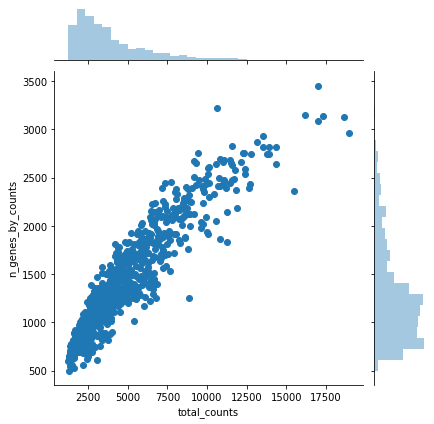

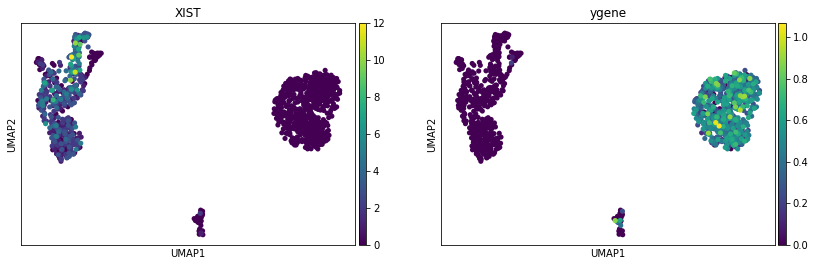

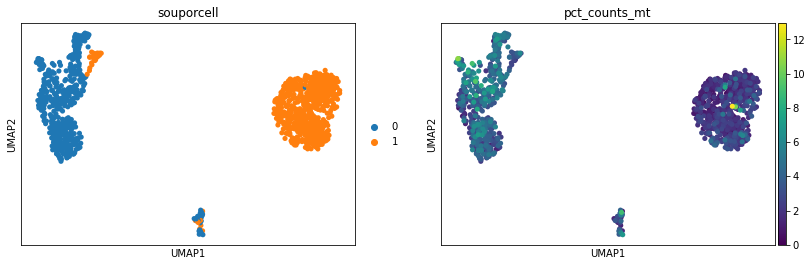

demultiplexed P1_iALLM in first run have  636  cells
demultiplexed P2_iALLF in first run have  499  cells


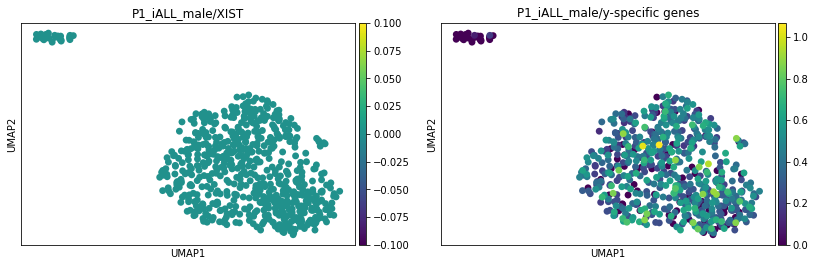

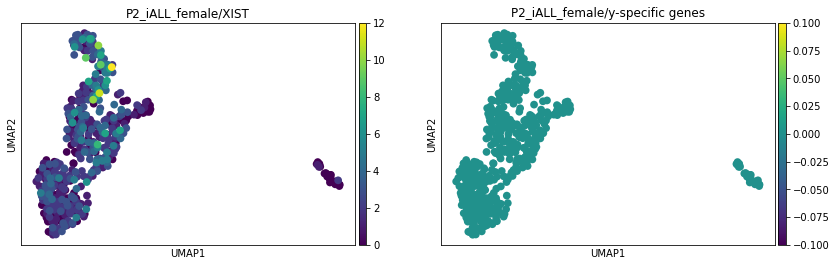

In [2]:
# Read SoupX processed data
adata1 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_1/P1_iALLM_P2_iALLF_Dx_run1_strained/', var_names='gene_symbols')
adata1.raw = adata1
print('First run: multiplexed P1_iALL_male with P2_iALL_female after SoupX have ', adata1.shape[0], ' cells')
sc.pp.filter_cells(adata1, min_genes=200)
adata1.var['mt'] = adata1.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata1 = adata1[adata1.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata1.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata1, counts_per_cell_after=1e4)
sc.pp.log1p(adata1)
sc.pp.neighbors(adata1)
sc.tl.umap(adata1)
sorcell = pd.read_csv('data/single_cell_data/P1_iALLM_P2_iALLF_Dx_run1_clusters.tsv', sep = '\t', index_col=0)
sorcell = sorcell[sorcell.status == 'singlet']
adata1 = adata1[adata1.obs_names.isin(sorcell.index)].copy()

adata1.obs['souporcell'] = sorcell.assignment

# we use combination of Y-specific genes
adata1.obs['ygene']= np.mean(adata1[:, ['RPS4Y1', 'ZFY', 'DDX3Y', 'UTY', 'TMSB4Y', 'KDM5D', 'EIF1AY']].X, 1)

sc.pl.umap(adata1, color = ['XIST', 'ygene'], ncols = 2)
sc.pl.umap(adata1, color = ['souporcell','pct_counts_mt'])

adataP1_iALLMrun1 = adata1[adata1.obs['souporcell'] == '1']
adataP2_iALLFrun1 = adata1[adata1.obs['souporcell'] == '0']
print('demultiplexed P1_iALLM in first run have ', adataP1_iALLMrun1.shape[0], ' cells')
print('demultiplexed P2_iALLF in first run have ', adataP2_iALLFrun1.shape[0], ' cells')

sc.pp.neighbors(adataP1_iALLMrun1)
sc.tl.umap(adataP1_iALLMrun1)

sc.pp.neighbors(adataP2_iALLFrun1)
sc.tl.umap(adataP2_iALLFrun1)

sc.pl.umap(adataP1_iALLMrun1, color = ['XIST', 'ygene'], ncols = 2, title = ['P1_iALL_male/XIST','P1_iALL_male/y-specific genes'])
sc.pl.umap(adataP2_iALLFrun1, color = ['XIST', 'ygene'], ncols = 2, title = ['P2_iALL_female/XIST','P2_iALL_female/y-specific genes'])


And now the same for second channel

Second run: multiplexed P1_iALL_male with P2_iALL_female after SoupX have  1209  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'souporcell' as categorical
... storing 'feature_types' as categorical


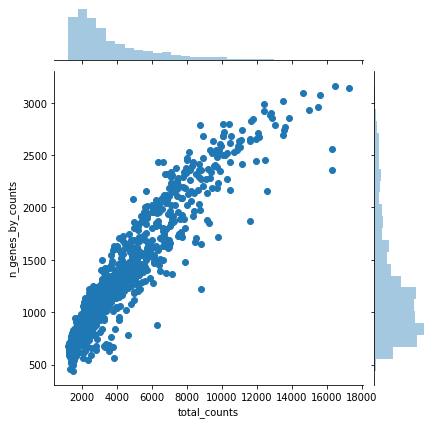

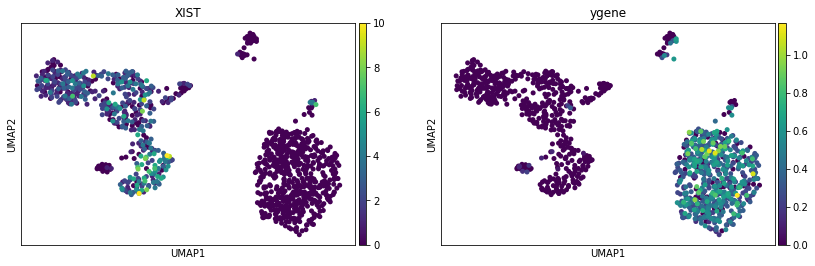

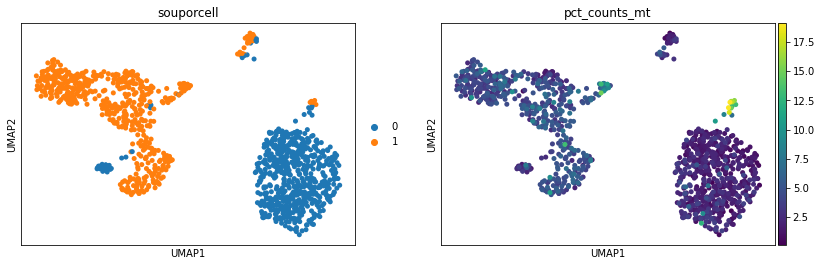

demultiplexed P1_iALLM in second run have  638  cells
demultiplexed P2_iALLF in second run have  548  cells


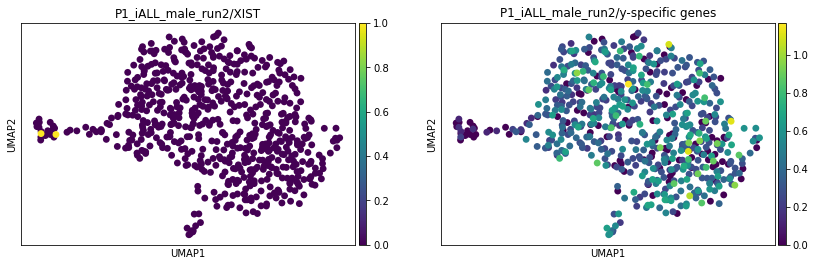

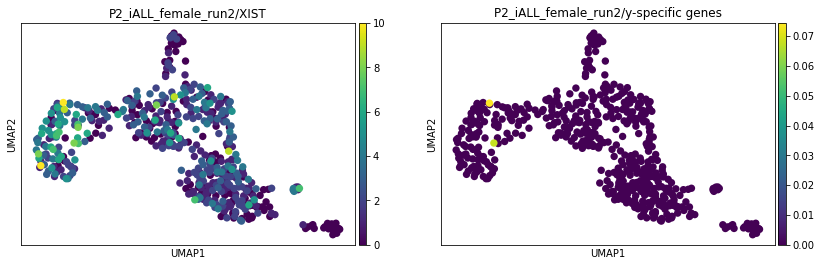

In [3]:
# Read SoupX processed data
adata2 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_1/P1_iALLM_P2_iALLF_Dx_run2_strained/', var_names='gene_symbols')
adata2.raw = adata2
print('Second run: multiplexed P1_iALL_male with P2_iALL_female after SoupX have ', adata2.shape[0], ' cells')
sc.pp.filter_cells(adata2, min_genes=200)
adata2.var['mt'] = adata2.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata2 = adata2[adata2.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata2.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
sorcell = pd.read_csv('data/single_cell_data/P1_iALLM_P2_iALLF_Dx_run2_clusters.tsv', sep = '\t', index_col=0)
sorcell = sorcell[sorcell.status == 'singlet']
adata2 = adata2[adata2.obs_names.isin(sorcell.index)].copy()

adata2.obs['souporcell'] = sorcell.assignment

adata2.obs['ygene']= np.mean(adata2[:, ['RPS4Y1', 'ZFY', 'DDX3Y', 'UTY', 'TMSB4Y', 'KDM5D', 'EIF1AY']].X, 1)

sc.pl.umap(adata2, color = ['XIST', 'ygene'], ncols = 2)
sc.pl.umap(adata2, color = ['souporcell','pct_counts_mt'])

adataP1_iALLMrun2 = adata2[adata2.obs['souporcell'] == '0']
adataP2_iALLFrun2 = adata2[adata2.obs['souporcell'] == '1']
print('demultiplexed P1_iALLM in second run have ', adataP1_iALLMrun2.shape[0], ' cells')
print('demultiplexed P2_iALLF in second run have ', adataP2_iALLFrun2.shape[0], ' cells')

sc.pp.neighbors(adataP1_iALLMrun2)
sc.tl.umap(adataP1_iALLMrun2)

sc.pp.neighbors(adataP2_iALLFrun2)
sc.tl.umap(adataP2_iALLFrun2)

sc.pl.umap(adataP1_iALLMrun2, color = ['XIST', 'ygene'], ncols = 2, title = ['P1_iALL_male_run2/XIST','P1_iALL_male_run2/y-specific genes'])
sc.pl.umap(adataP2_iALLFrun2, color = ['XIST', 'ygene'], ncols = 2, title = ['P2_iALL_female_run2/XIST','P2_iALL_female_run2/y-specific genes'])


We will combine single cell data from 2 channels into one object (and you can optionally save it as h5ad, I have commented the line due to the github size limit). AnnData object contains normalized and log processed data in adata.X slot but we can get raw counts back using following command:
`adata_RAW = adata.raw.to_adata()`

combining P1_iALL (male) from 2 channels:


... storing 'souporcell' as categorical


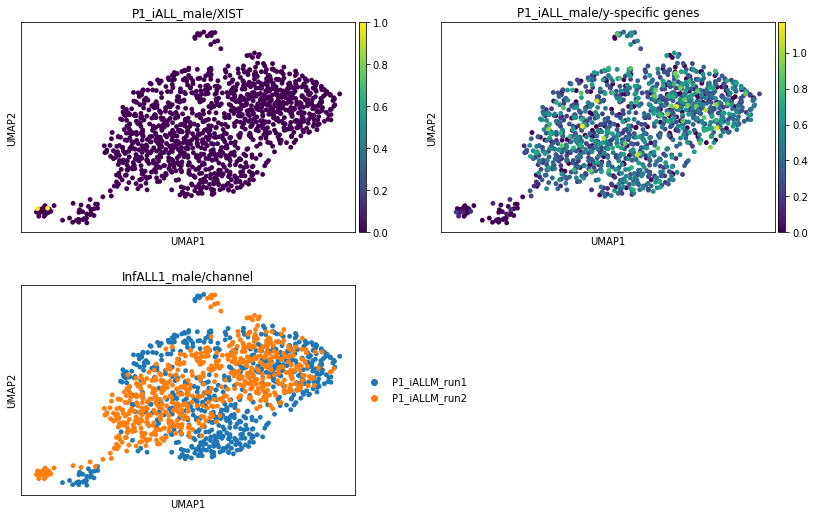

Combined P1_iALL (male) from both runs have  1274  cells
combining P2_iALL (female) from 2 channels:


... storing 'souporcell' as categorical


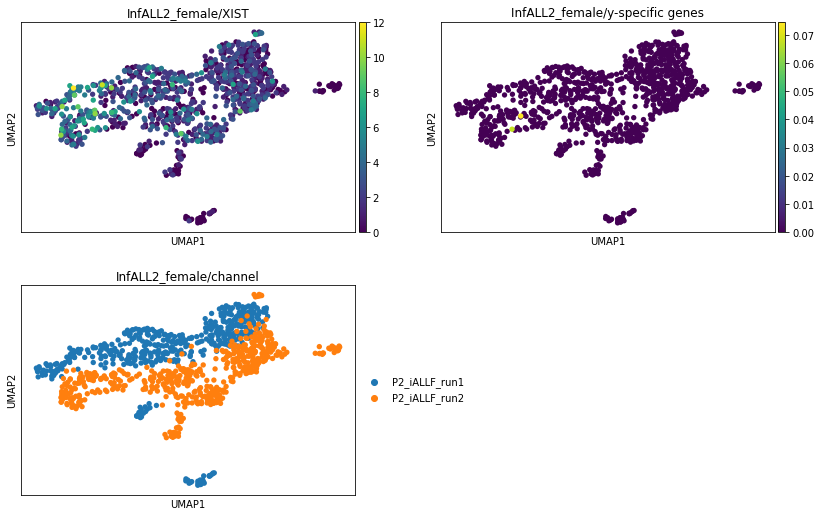

Combined P2_iALL (female) from both runs have  1047  cells


In [6]:
from scipy import io

print('combining P1_iALL (male) from 2 channels:')
adata_P1_iALL = adataP1_iALLMrun1.concatenate(adataP1_iALLMrun2, batch_categories=['P1_iALLM_run1', 'P1_iALLM_run2'])
sc.pp.neighbors(adata_P1_iALL)
sc.tl.umap(adata_P1_iALL)
sc.pl.umap(adata_P1_iALL, color = ['XIST', 'ygene', 'batch'], ncols = 2, title = ['P1_iALL_male/XIST','P1_iALL_male/y-specific genes', 'InfALL1_male/channel'])
print('Combined P1_iALL (male) from both runs have ', adata_P1_iALL.shape[0], ' cells')
#adata_P1_iALL.write_h5ad('data/single_cell_data/final_h5ad/P1_iALLM_Dx_combined_RAW.h5ad')

print('combining P2_iALL (female) from 2 channels:')
adata_P2_iALL = adataP2_iALLFrun1.concatenate(adataP2_iALLFrun2, batch_categories=['P2_iALLF_run1', 'P2_iALLF_run2'])
sc.pp.neighbors(adata_P2_iALL)
sc.tl.umap(adata_P2_iALL)
sc.pl.umap(adata_P2_iALL, color = ['XIST', 'ygene', 'batch'], ncols = 2, title = ['InfALL2_female/XIST','InfALL2_female/y-specific genes', 'InfALL2_female/channel'])
print('Combined P2_iALL (female) from both runs have ', adata_P2_iALL.shape[0], ' cells')
#adata_P2_iALL.write_h5ad('data/single_cell_data/final_h5ad/P2_iALLF_Dx_combined_RAW.h5ad')


Let's process last sample from the first experiment: P9_iAML

P9_iAML after SoupX have  1209  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'feature_types' as categorical


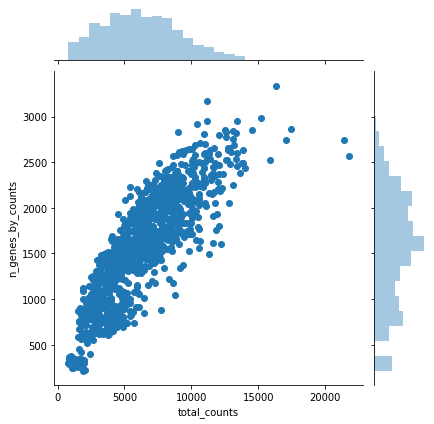

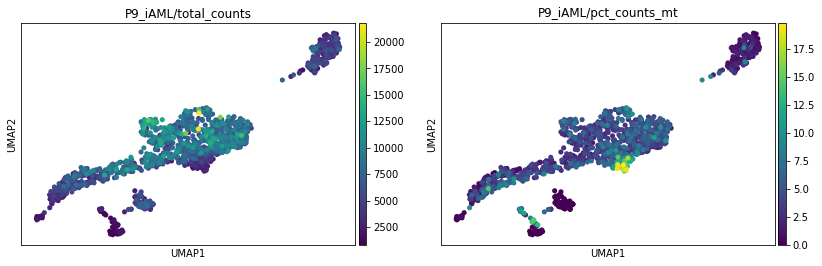

After filtering and preprocessing P9_iAML have  1149  cells


In [6]:
# Read SoupX processed data
adata_P9_iAML = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_1/P9_iAML_Dx_strained/', var_names='gene_symbols')
adata_P9_iAML.raw = adata_P9_iAML
adata_P9_iAML.obs_names = adata_P9_iAML.obs_names+'-P9_iAML'
print('P9_iAML after SoupX have ', adata_P9_iAML.shape[0], ' cells')
sc.pp.filter_cells(adata_P9_iAML, min_genes=200)
adata_P9_iAML.var['mt'] = adata_P9_iAML.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata_P9_iAML, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata_P9_iAML = adata_P9_iAML[adata_P9_iAML.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata_P9_iAML.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata_P9_iAML, counts_per_cell_after=1e4)
sc.pp.log1p(adata_P9_iAML)
sc.pp.neighbors(adata_P9_iAML)
sc.tl.umap(adata_P9_iAML)
sc.pl.umap(adata_P9_iAML, color = ['total_counts','pct_counts_mt'], title = ['P9_iAML/total_counts','P9_iAML/pct_counts_mt'])

print('After filtering and preprocessing P9_iAML have ', adata_P9_iAML.shape[0], ' cells')
#adata_P9_iAML.write_h5ad('data/single_cell_data/final_h5ad/P9_iAML_Dx_RAW.h5ad')


# Experiment #2

In this experiment we have one channel (runs) of InfALL3 multiplexed with InfAML2 and two channels of InfALL4. We will process them in the same way as other data.

Let's start with first run of mutiplexed data:

Multiplexed P3_iALL with P10_iAML after SoupX have  1119  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'souporcell' as categorical
... storing 'feature_types' as categorical


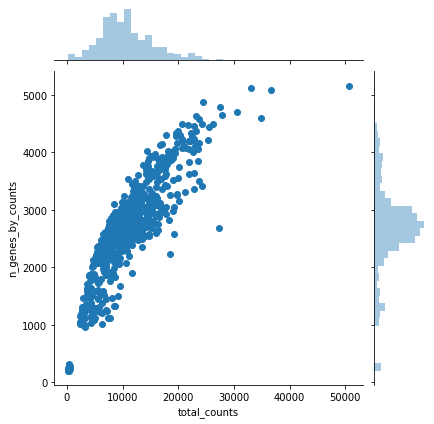

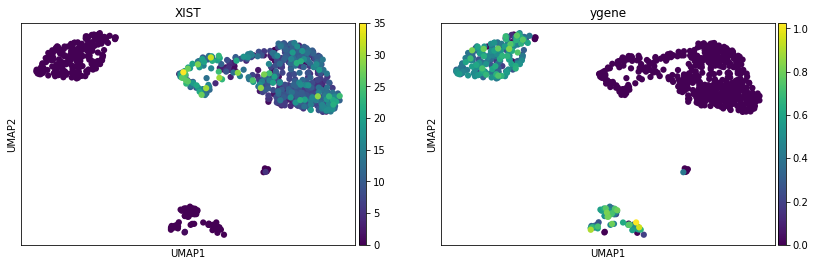

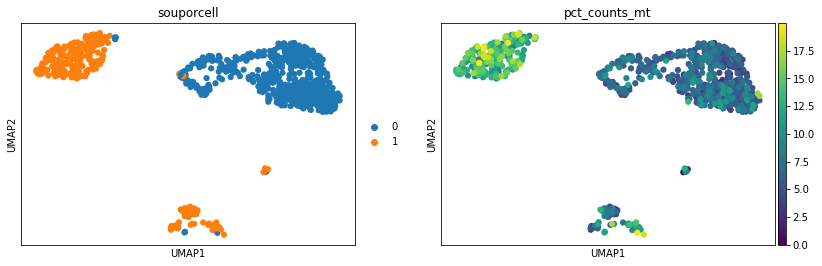

demultiplexed P10_iAML (male) have  250  cells
demultiplexed P3_iALL (female) have  521  cells


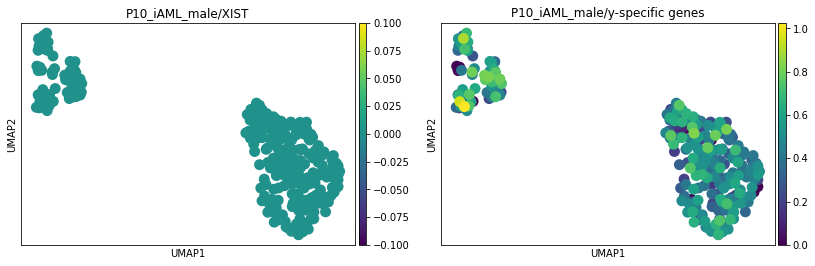

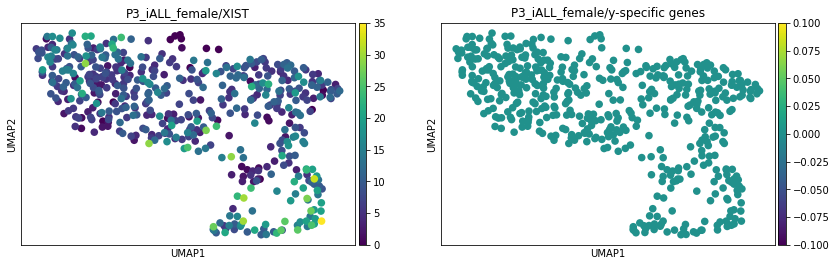

After filtering and preprocessing P10_iAML have  250  cells
After filtering and preprocessing P3_iALL have  521  cells


In [7]:
# Read SoupX processed data
adata1 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_2/P3_iALL_P10_iAML_Dx_run1_strained/', var_names='gene_symbols')
adata1.raw = adata1
print('Multiplexed P3_iALL with P10_iAML after SoupX have ', adata1.shape[0], ' cells')
sc.pp.filter_cells(adata1, min_genes=200)
adata1.var['mt'] = adata1.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata1 = adata1[adata1.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata1.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata1, counts_per_cell_after=1e4)
sc.pp.log1p(adata1)
sc.pp.neighbors(adata1)
sc.tl.umap(adata1)
sorcell = pd.read_csv('data/single_cell_data/P3_iALL_P10_iAML_Dx_run1_clusters.tsv', sep = '\t', index_col=0)
sorcell = sorcell[sorcell.status == 'singlet']
adata1 = adata1[adata1.obs_names.isin(sorcell.index)].copy()

adata1.obs['souporcell'] = sorcell.assignment

adata1.obs['ygene']= np.mean(adata1[:, ['RPS4Y1', 'ZFY', 'DDX3Y', 'UTY', 'TMSB4Y', 'KDM5D', 'EIF1AY']].X, 1)

sc.pl.umap(adata1, color = ['XIST', 'ygene'], ncols = 2)
sc.pl.umap(adata1, color = ['souporcell','pct_counts_mt'])

adata_P10_iAML_male = adata1[adata1.obs['souporcell'] == '1']
adata_P10_iAML_male.obs_names = adata_P10_iAML_male.obs_names+'-P10_iAML'

adata_P3_iALL_female = adata1[adata1.obs['souporcell'] == '0']
adata_P3_iALL_female.obs_names = adata_P3_iALL_female.obs_names+'-P3_iALL'

print('demultiplexed P10_iAML (male) have ', adata_P10_iAML_male.shape[0], ' cells')
print('demultiplexed P3_iALL (female) have ', adata_P3_iALL_female.shape[0], ' cells')

sc.pp.neighbors(adata_P10_iAML_male)
sc.tl.umap(adata_P10_iAML_male)

sc.pp.neighbors(adata_P3_iALL_female)
sc.tl.umap(adata_P3_iALL_female)

sc.pl.umap(adata_P10_iAML_male, color = ['XIST', 'ygene'], ncols = 2, title = ['P10_iAML_male/XIST','P10_iAML_male/y-specific genes'])
sc.pl.umap(adata_P3_iALL_female, color = ['XIST', 'ygene'], ncols = 2, title = ['P3_iALL_female/XIST','P3_iALL_female/y-specific genes'])

print('After filtering and preprocessing P10_iAML have ', adata_P10_iAML_male.shape[0], ' cells')
#adata_P10_iAML_male.write_h5ad('data/single_cell_data/P10_iAML_Dx_RAW.h5ad')

print('After filtering and preprocessing P3_iALL have ', adata_P3_iALL_female.shape[0], ' cells')
#adata_P3_iALL_female.write_h5ad('data/single_cell_data/P3_iALL_Dx_RAW.h5ad')


And now load the data for P4_iALL:

First run: P4_iALL after SoupX have  466  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


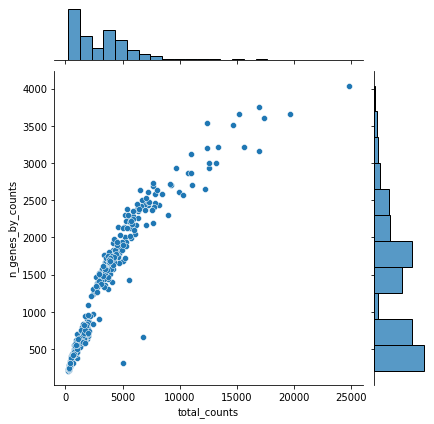

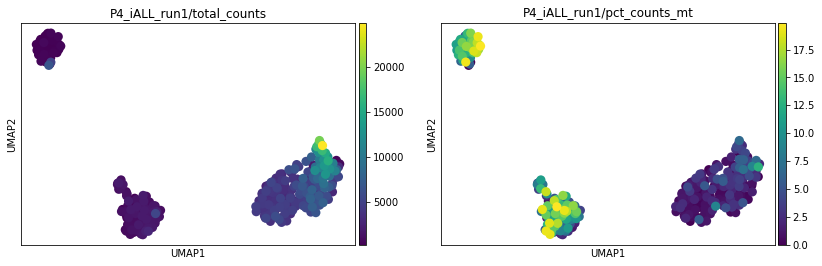

Second run: P4_iALL after SoupX have  370  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


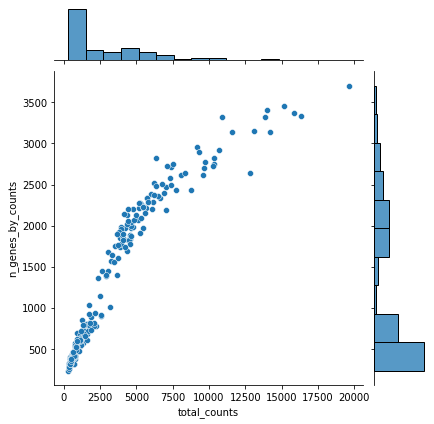

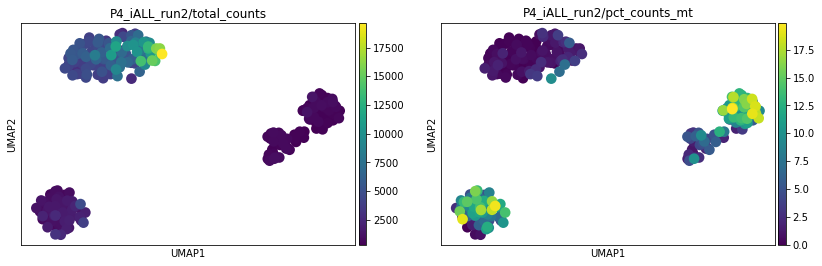

P4_iALL: two channels combined have  616  cells


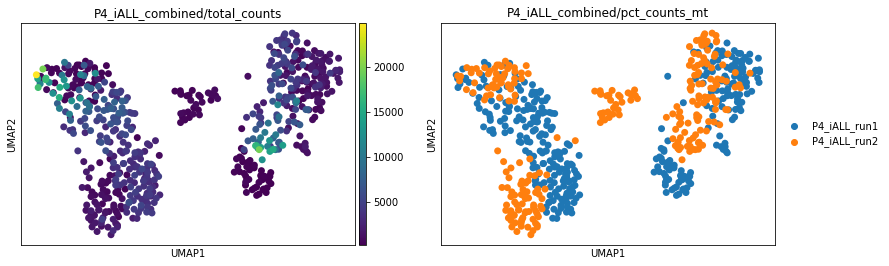

In [9]:
# Read SoupX processed data

adata1 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_2/P4_iALL_Dx_run1_strained/', var_names='gene_symbols')
adata1.raw = adata1
print('First run: P4_iALL after SoupX have ', adata1.shape[0], ' cells')
sc.pp.filter_cells(adata1, min_genes=200)
adata1.var['mt'] = adata1.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata1 = adata1[adata1.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata1.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata1, counts_per_cell_after=1e4)
sc.pp.log1p(adata1)
sc.pp.neighbors(adata1)
sc.tl.umap(adata1)

sc.pl.umap(adata1, color = ['total_counts','pct_counts_mt'], title = ['P4_iALL_run1/total_counts','P4_iALL_run1/pct_counts_mt'])



adata2 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_2/P4_iALL_Dx_run2_strained/', var_names='gene_symbols')
adata2.raw = adata2
print('Second run: P4_iALL after SoupX have ', adata2.shape[0], ' cells')
sc.pp.filter_cells(adata2, min_genes=200)
adata2.var['mt'] = adata2.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata2 = adata2[adata2.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata2.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
sc.pl.umap(adata2, color = ['total_counts','pct_counts_mt'], title = ['P4_iALL_run2/total_counts','P4_iALL_run2/pct_counts_mt'])


adata_P4_iALL = adata1.concatenate(adata2, batch_categories = ['P4_iALL_run1', 'P4_iALL_run2'])
print('P4_iALL: two channels combined have ', adata_P4_iALL.shape[0], ' cells')
sc.pp.neighbors(adata_P4_iALL)
sc.tl.umap(adata_P4_iALL)
sc.pl.umap(adata_P4_iALL, color = ['total_counts','batch'], title = ['P4_iALL_combined/total_counts','P4_iALL_combined/pct_counts_mt'])

#adata_P4_iALL.write_h5ad('data/single_cell_data/final_h5ad/P4_iALL_Dx_RAW.h5ad')



# Experiment 3
This experiment consisted of one channel for P5_iALL multiplexed with CS_iALL (class switch case), one channel of each of: P6_iALL, P7_iALL7_NUTM1 and P8_iALL_ETV6

CS_iALL was not included in the analysis later on so we will ignore it. P5_iALL is female so we will extract the cells with cluster id corresponding to the expression of XIST.

Multiplexed P5_iALL with CS_iALL after SoupX have  3232  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'souporcell' as categorical


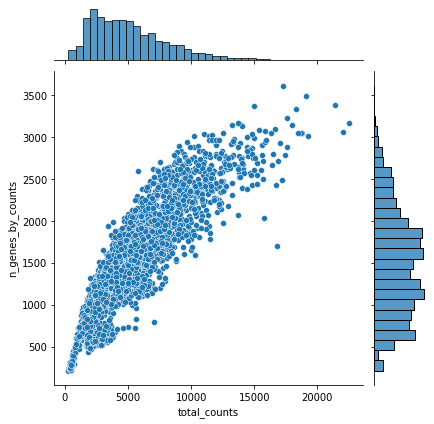

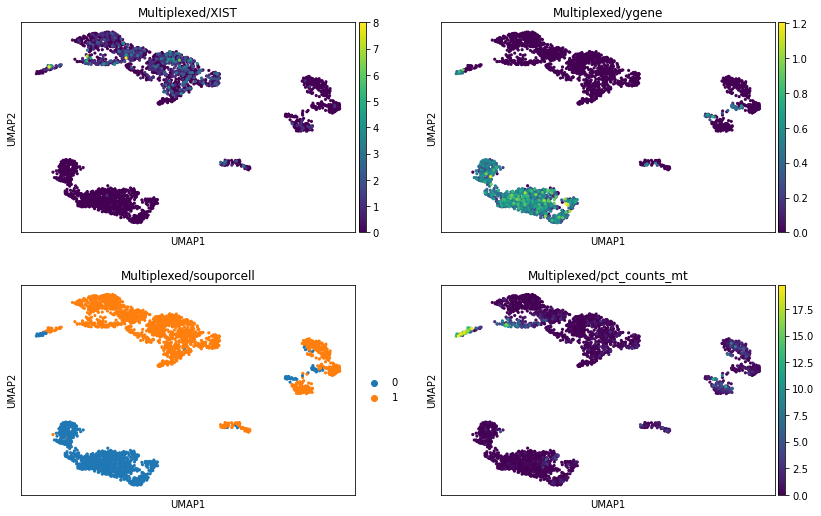

demultiplexed P5_iALL (female) have  1878  cells


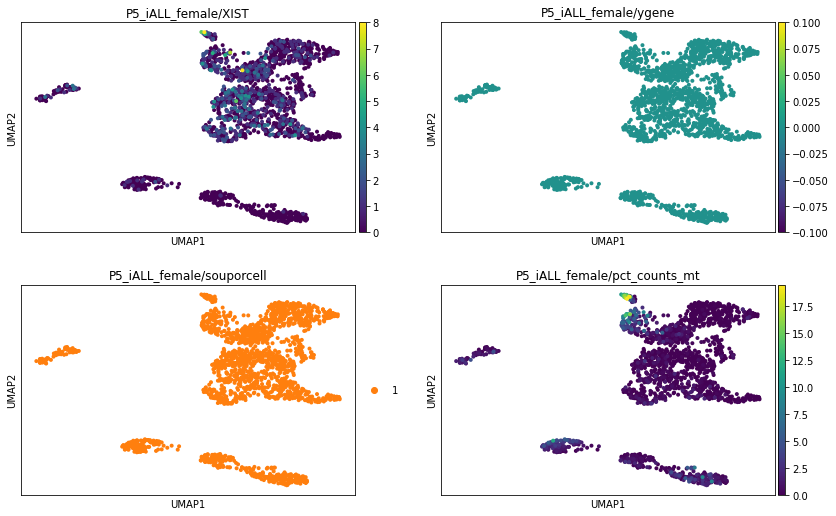

In [10]:
adata = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_3/P5_iALL_CS_iALL_L826_LK387_strained/')
adata.raw = adata
print('Multiplexed P5_iALL with CS_iALL after SoupX have ', adata.shape[0], ' cells')

sc.pp.filter_cells(adata, min_genes=200)
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata = adata[adata.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sorc = pd.read_csv('data/single_cell_data/P5_iALL_CS_iALL_L826_LK387_clusters.csv', sep = '\t',index_col=0)
sorc = sorc[sorc.status == 'singlet']
adata = adata[adata.obs_names.isin(sorc.index)].copy()

adata.obs['souporcell'] = sorc.assignment
adata.obs['ygene']= np.mean(adata[:, ['RPS4Y1', 'ZFY', 'DDX3Y', 'UTY', 'TMSB4Y', 'KDM5D', 'EIF1AY']].X, 1)

sc.pl.umap(adata, color = ['XIST', 'ygene', 'souporcell','pct_counts_mt'], ncols = 2, 
           title = ['Multiplexed/XIST', 'Multiplexed/ygene', 'Multiplexed/souporcell','Multiplexed/pct_counts_mt'])

adata_P5_iALL = adata[adata.obs.souporcell == '1'].copy() #LK387 female infant KMT2A B-ALL
adata_P5_iALL.obs_names = adata_P5_iALL.obs_names+'-P5_iALL'

print('demultiplexed P5_iALL (female) have ', adata_P5_iALL.shape[0], ' cells')

sc.pp.neighbors(adata_P5_iALL)
sc.tl.umap(adata_P5_iALL)
sc.pl.umap(adata_P5_iALL, color = ['XIST', 'ygene', 'souporcell','pct_counts_mt'], ncols = 2,
          title = ['P5_iALL_female/XIST', 'P5_iALL_female/ygene', 'P5_iALL_female/souporcell','P5_iALL_female/pct_counts_mt'])

#adata_P5_iALL.write_h5ad('data/single_cell_data/final_h5ad/P5_iALL_Dx_RAW.h5ad')


Now the same preprocessing for other samples

P6_iALL after SoupX have  8175  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


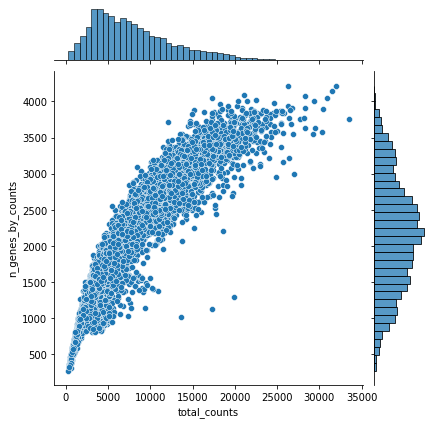

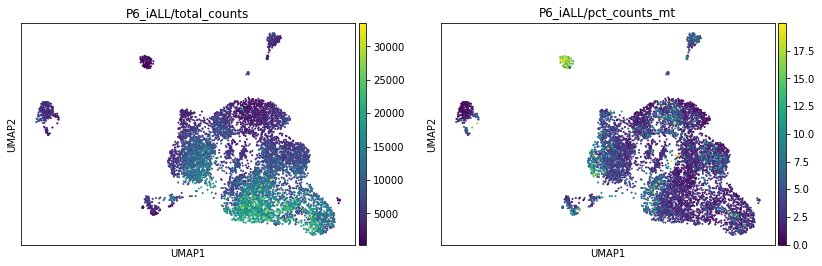

After filtering and preprocessing P6_iALL have  7141  cells


In [11]:
# Read SoupX processed data
adata_P6_iALL = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_3/P6_iALL_L876_Dx_strained/', var_names='gene_symbols')
adata_P6_iALL.raw = adata_P6_iALL
adata_P6_iALL.obs_names = adata_P6_iALL.obs_names+'-P6_iALL'

print('P6_iALL after SoupX have ', adata_P6_iALL.shape[0], ' cells')
sc.pp.filter_cells(adata_P6_iALL, min_genes=200)
adata_P6_iALL.var['mt'] = adata_P6_iALL.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata_P6_iALL, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata_P6_iALL = adata_P6_iALL[adata_P6_iALL.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata_P6_iALL.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata_P6_iALL, counts_per_cell_after=1e4)
sc.pp.log1p(adata_P6_iALL)
sc.pp.neighbors(adata_P6_iALL)
sc.tl.umap(adata_P6_iALL)
sc.pl.umap(adata_P6_iALL, color = ['total_counts','pct_counts_mt'], title = ['P6_iALL/total_counts','P6_iALL/pct_counts_mt'])

print('After filtering and preprocessing P6_iALL have ', adata_P6_iALL.shape[0], ' cells')
#adata_P6_iALL.write_h5ad('data/single_cell_data/final_h5ad/P6_iALL_Dx_RAW.h5ad')


P7_iALL_NUTM1 after SoupX have  6805  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


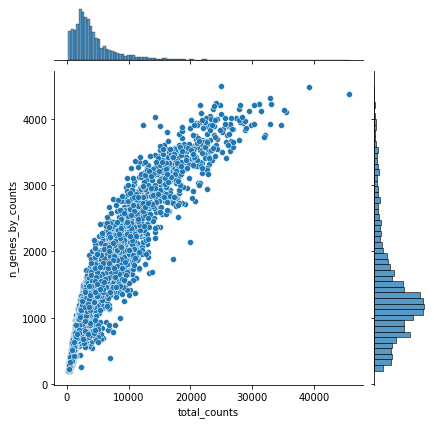

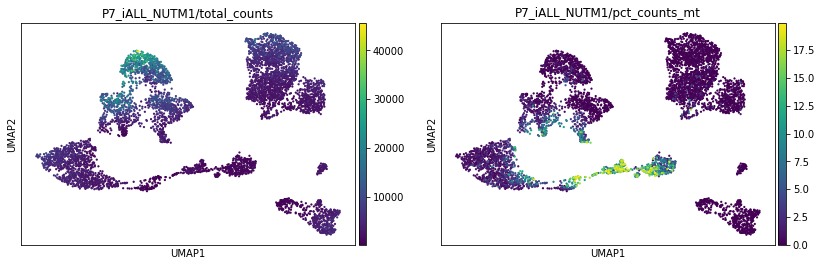

After filtering and preprocessing P7_iALL_NUTM1 have  6017  cells


In [12]:
# Read SoupX processed data
adata_P7_NUTM1 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_3/P7_iALL_NUTM1_Jacks_Dx_strained/', var_names='gene_symbols')
adata_P7_NUTM1.raw = adata_P7_NUTM1
adata_P7_NUTM1.obs_names = adata_P7_NUTM1.obs_names+'-P7_iALL_NUTM1'

print('P7_iALL_NUTM1 after SoupX have ', adata_P7_NUTM1.shape[0], ' cells')
sc.pp.filter_cells(adata_P7_NUTM1, min_genes=200)
adata_P7_NUTM1.var['mt'] = adata_P7_NUTM1.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata_P7_NUTM1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata_P7_NUTM1 = adata_P7_NUTM1[adata_P7_NUTM1.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata_P7_NUTM1.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata_P7_NUTM1, counts_per_cell_after=1e4)
sc.pp.log1p(adata_P7_NUTM1)
sc.pp.neighbors(adata_P7_NUTM1)
sc.tl.umap(adata_P7_NUTM1)
sc.pl.umap(adata_P7_NUTM1, color = ['total_counts','pct_counts_mt'], title = ['P7_iALL_NUTM1/total_counts','P7_iALL_NUTM1/pct_counts_mt'])

print('After filtering and preprocessing P7_iALL_NUTM1 have ', adata_P7_NUTM1.shape[0], ' cells')
#adata_P7_NUTM1.write_h5ad('data/single_cell_data/final_h5ad/P7_iALL_NUTM1_Dx_RAW.h5ad')


P8_iALL_ETV6 after SoupX have  9199  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


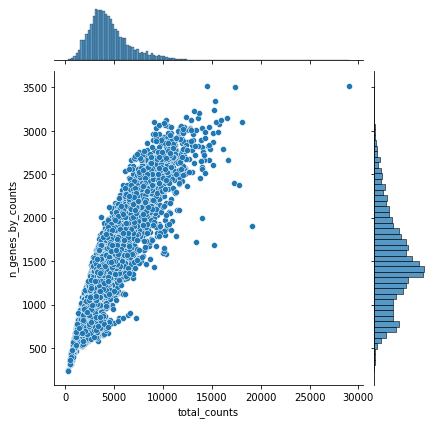

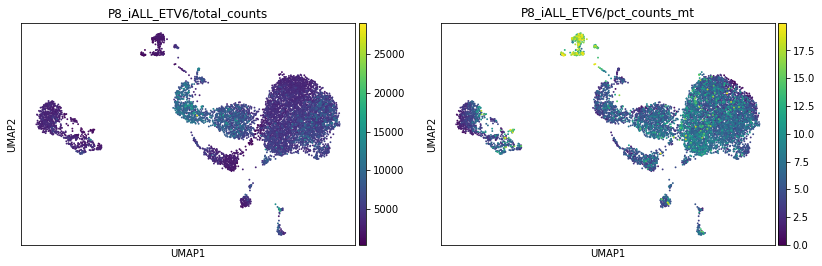

After filtering and preprocessing P8_iALL_ETV6 have  8474  cells


In [13]:
# Read SoupX processed data
adata_P8_iALL_ETV6 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_3/P8_iALL_ETV6_LK326_Dx_strained/', var_names='gene_symbols')
adata_P8_iALL_ETV6.raw = adata_P8_iALL_ETV6
adata_P8_iALL_ETV6.obs_names = adata_P8_iALL_ETV6.obs_names+'-P8_iALL_ETV6'

print('P8_iALL_ETV6 after SoupX have ', adata_P8_iALL_ETV6.shape[0], ' cells')
sc.pp.filter_cells(adata_P8_iALL_ETV6, min_genes=200)
adata_P8_iALL_ETV6.var['mt'] = adata_P8_iALL_ETV6.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata_P8_iALL_ETV6, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata_P8_iALL_ETV6 = adata_P8_iALL_ETV6[adata_P8_iALL_ETV6.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata_P8_iALL_ETV6.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata_P8_iALL_ETV6, counts_per_cell_after=1e4)
sc.pp.log1p(adata_P8_iALL_ETV6)
sc.pp.neighbors(adata_P8_iALL_ETV6)
sc.tl.umap(adata_P8_iALL_ETV6)
sc.pl.umap(adata_P8_iALL_ETV6, color = ['total_counts','pct_counts_mt'], title = ['P8_iALL_ETV6/total_counts','P8_iALL_ETV6/pct_counts_mt'])

print('After filtering and preprocessing P8_iALL_ETV6 have ', adata_P8_iALL_ETV6.shape[0], ' cells')
#adata_P8_iALL_ETV6.write_h5ad('data/single_cell_data/final_h5ad/P8_iALL_ETV6_Dx_RAW.h5ad')


<a id='umap'></a>



# UMAPs

For each of single cell samples Laura Jardine have annotated cluster of cells as either cancerous or non-cancerous cells according to the expression of immunophenotype genes as mentioned in the the paper and Supp.Figures S1 and S2. 
I have clustered the data and assigned either /Cancer or /Normal in the column "patient_cancer" for each of the samples and saved h5ad object with the name extension \_cancerInfo.h5ad for each sample in final_h5ad folder.

We can now read the h5ad object for each sample and merge them together so that we can show combined UMAP (like in Figure 2B).

Please unzip h5ad files first if you cloned github repository and reading files from here

In [16]:
import scanpy as sc
import pandas as pd


all_aml_files = ['data/single_cell_data/final_h5ad/P1_iALLM_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P2_iALLF_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P3_iALL_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P4_iALL_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P5_iALL_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P6_iALL_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P7_iALL_NUTM1_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P8_iALL_ETV6_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P9_iAML_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P10_iAML_Dx_cancerInfo.h5ad']
sample_names = ['P1_iALLM', 'P2_iALL','P3_iALL',
                'P4_iALL', 'P5_iALL','P6_iALL',
                'P7_iALL_NUTM1','P8_iALL_ETV6','P9_iAML','P10_iAML']

adata_ALL_all = []
for i, filen in enumerate(all_aml_files):
    print(filen)
    adata_ALL_all.append(sc.read_h5ad(filen))

adata_ALL_new = adata_ALL_all[0].concatenate(adata_ALL_all[1:], batch_categories=sample_names)
adata_ALL_new.obs_names = pd.Series(adata_ALL_new.obs_names).str.rsplit('-', n=1, expand = True)[0].values
adata_ALL_new.obs.head()


data/single_cell_data/final_h5ad/P1_iALLM_Dx_cancerInfo.h5ad
data/single_cell_data/final_h5ad/P2_iALLF_Dx_cancerInfo.h5ad
data/single_cell_data/final_h5ad/P3_iALL_Dx_cancerInfo.h5ad
data/single_cell_data/final_h5ad/P4_iALL_Dx_cancerInfo.h5ad
data/single_cell_data/final_h5ad/P5_iALL_Dx_cancerInfo.h5ad
data/single_cell_data/final_h5ad/P6_iALL_Dx_cancerInfo.h5ad
data/single_cell_data/final_h5ad/P7_iALL_NUTM1_Dx_cancerInfo.h5ad
data/single_cell_data/final_h5ad/P8_iALL_ETV6_Dx_cancerInfo.h5ad
data/single_cell_data/final_h5ad/P9_iAML_Dx_cancerInfo.h5ad
data/single_cell_data/final_h5ad/P10_iAML_Dx_cancerInfo.h5ad


,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_counts,souporcell,ygene,batch,patient_cancer,louvain
AAACGGGAGAAGGGTA-1/P1_iALLM,1286,1286,3829.0,91.0,2.376600,3829.0,1,0.348242,P1_iALLM,P1_iALL/Cancer,3
AAACGGGCAGCTCGCA-1/P1_iALLM,729,729,2805.0,43.0,1.532977,2805.0,1,0.000000,P1_iALLM,P1_iALL/Normal,6
AAAGCAAGTAAGTAGT-1/P1_iALLM,633,633,1643.0,29.0,1.765064,1643.0,1,0.559480,P1_iALLM,P1_iALL/Cancer,0
AAAGCAATCAAGAAGT-1/P1_iALLM,993,993,2499.0,29.0,1.160464,2499.0,1,0.313940,P1_iALLM,P1_iALL/Cancer,4
AAAGTAGAGAGTACAT-1/P1_iALLM,934,934,2484.0,12.0,0.483092,2484.0,1,0.314705,P1_iALLM,P1_iALL/Cancer,0


... storing 'souporcell' as categorical
... storing 'louvain' as categorical


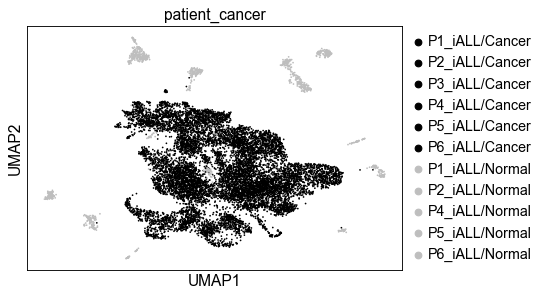

In [17]:
# some preprocessing to make sure that the text in figures are rendered properly
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# filter out to only include KMT2A-rearranged B-ALL (P1-6 iALL)
adata_ALL_ALL = adata_ALL_new[adata_ALL_new.obs.patient_cancer.str.contains('iALL')].copy()
adata_ALL_ALL = adata_ALL_ALL[~(adata_ALL_ALL.obs.patient_cancer.str.contains('ETV6')|
                             adata_ALL_ALL.obs.patient_cancer.str.contains('NUTM1'))].copy()

sc.pp.neighbors(adata_ALL_ALL)
sc.tl.umap(adata_ALL_ALL)

# Reorder category so that we have all "cancer" cells first and then "Normal"
adata_ALL_ALL.obs.patient_cancer = adata_ALL_ALL.obs.patient_cancer.astype('category')
obs_order = list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains('Cancer')].values))
obs_order.extend(list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains('Normal')].values)))

adata_ALL_ALL.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_ALL_ALL.obs['patient_cancer'] = adata_ALL_ALL.obs['patient_cancer'].sort_values()

sc.set_figure_params(figsize=[6,4], dpi_save=300)
adata_ALL_ALL.uns['patient_cancer_colors'] = ['#000000']*adata_ALL_ALL.obs['patient_cancer'].nunique()
adata_ALL_ALL.uns['patient_cancer_colors'][6:] = ['#BEBEBE']*5
f = sc.pl.umap(adata_ALL_ALL, color = 'patient_cancer',show=False)


... storing 'louvain' as categorical


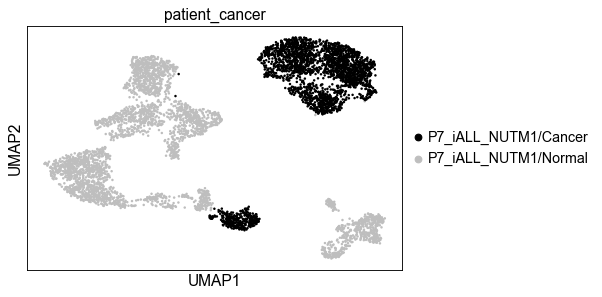

In [18]:
# Same for NUTM1
adata_ALL_ALL = adata_ALL_new[adata_ALL_new.obs.patient_cancer.str.contains('NUTM1')].copy()

sc.pp.neighbors(adata_ALL_ALL)
sc.tl.umap(adata_ALL_ALL)

adata_ALL_ALL.obs.patient_cancer = adata_ALL_ALL.obs.patient_cancer.astype('category')
base = r'^{}'
expr = '(?=.*{})'
obs_order = list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer'])))].values))
obs_order.extend(list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Normal'])))].values)))

adata_ALL_ALL.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_ALL_ALL.obs['patient_cancer'] = adata_ALL_ALL.obs['patient_cancer'].sort_values()

adata_ALL_ALL.uns['patient_cancer_colors'] = ['#000000']*adata_ALL_ALL.obs['patient_cancer'].nunique()
adata_ALL_ALL.uns['patient_cancer_colors'][1] = '#BEBEBE'
f = sc.pl.umap(adata_ALL_ALL, color = 'patient_cancer',show=False)


... storing 'louvain' as categorical


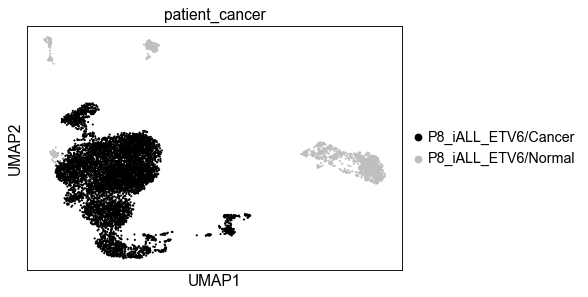

In [19]:
# Same for ETV6-RUNX1
adata_ALL_ALL = adata_ALL_new[adata_ALL_new.obs.patient_cancer.str.contains('ETV6')].copy()

sc.pp.neighbors(adata_ALL_ALL)
sc.tl.umap(adata_ALL_ALL)

adata_ALL_ALL.obs.patient_cancer = adata_ALL_ALL.obs.patient_cancer.astype('category')
base = r'^{}'
expr = '(?=.*{})'
obs_order = list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer'])))].values))
obs_order.extend(list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Normal'])))].values)))

adata_ALL_ALL.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_ALL_ALL.obs['patient_cancer'] = adata_ALL_ALL.obs['patient_cancer'].sort_values()

adata_ALL_ALL.uns['patient_cancer_colors'] = ['#000000']*adata_ALL_ALL.obs['patient_cancer'].nunique()
adata_ALL_ALL.uns['patient_cancer_colors'][1] = '#BEBEBE'
f = sc.pl.umap(adata_ALL_ALL, color = 'patient_cancer',show=False)


... storing 'louvain' as categorical


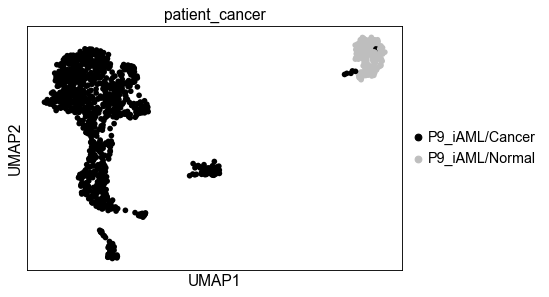

In [20]:
# Now AML: P9_iAML
adata_ALL_ALL = adata_ALL_new[adata_ALL_new.obs.patient_cancer.str.contains('P9')].copy()

sc.pp.neighbors(adata_ALL_ALL)
sc.tl.umap(adata_ALL_ALL)

adata_ALL_ALL.obs.patient_cancer = adata_ALL_ALL.obs.patient_cancer.astype('category')
base = r'^{}'
expr = '(?=.*{})'
obs_order = list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer'])))].values))
obs_order.extend(list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Normal'])))].values)))

adata_ALL_ALL.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_ALL_ALL.obs['patient_cancer'] = adata_ALL_ALL.obs['patient_cancer'].sort_values()

adata_ALL_ALL.uns['patient_cancer_colors'] = ['#000000']*adata_ALL_ALL.obs['patient_cancer'].nunique()
adata_ALL_ALL.uns['patient_cancer_colors'][1] = '#BEBEBE'
f = sc.pl.umap(adata_ALL_ALL, color = 'patient_cancer',show=False)


... storing 'souporcell' as categorical
... storing 'louvain' as categorical


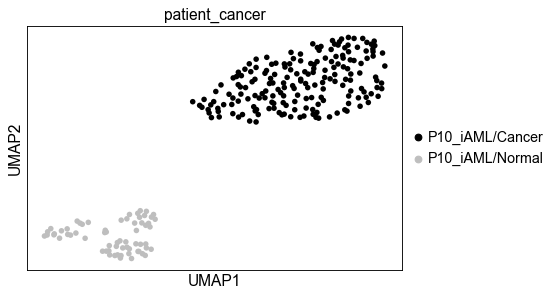

In [21]:
# And last sample - megakaryocytic AML (P10_iAML)

adata_ALL_ALL = adata_ALL_new[adata_ALL_new.obs.patient_cancer.str.contains('P10')].copy()

sc.pp.neighbors(adata_ALL_ALL)
sc.tl.umap(adata_ALL_ALL)

adata_ALL_ALL.obs.patient_cancer = adata_ALL_ALL.obs.patient_cancer.astype('category')
base = r'^{}'
expr = '(?=.*{})'
obs_order = list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer'])))].values))
obs_order.extend(list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Normal'])))].values)))

adata_ALL_ALL.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_ALL_ALL.obs['patient_cancer'] = adata_ALL_ALL.obs['patient_cancer'].sort_values()

adata_ALL_ALL.uns['patient_cancer_colors'] = ['#000000']*adata_ALL_ALL.obs['patient_cancer'].nunique()
adata_ALL_ALL.uns['patient_cancer_colors'][1] = '#BEBEBE'
f = sc.pl.umap(adata_ALL_ALL, color = 'patient_cancer',show=False, size=100)


<a id='logreg'></a>


# Logistic regression
Results of logistic regression analysis, i.e. single cell cancer to normal comparison. Scores represent the probability that particular leukemia single cell is transciptomically similar to all the cells belonging to the particular normal reference cell type. Max probability = 1 (very similar), min probability = 0 (very DISsimilar) and 0.5 represents somewhat random similarity.

/Users/ek12/homebrew/lib/python3.7/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  _ = ax.pcolor(_color_df, **kwds)


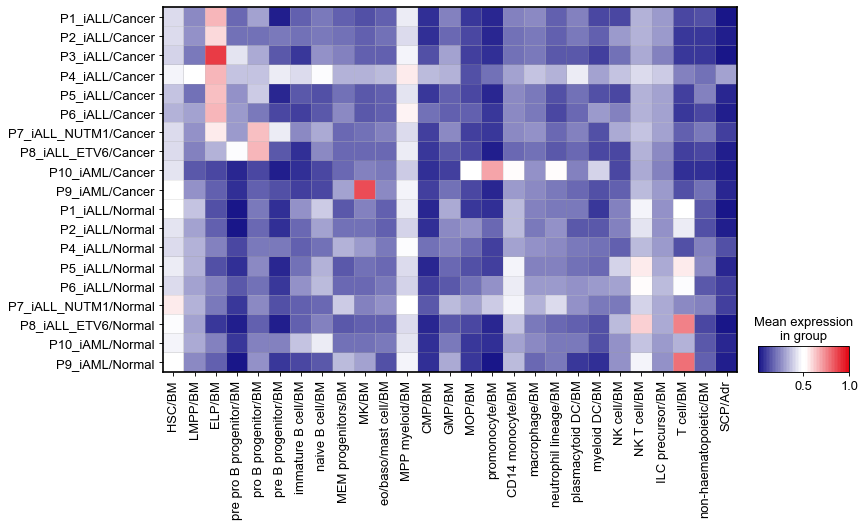

In [22]:
#Figure 2A

import pandas as pd
import scanpy as sc
from matplotlib.colors import LinearSegmentedColormap

tmpf = pd.read_csv('analysis_results/logreg/InfALL_allSAMPLES_LogregFBM.csv', header=0, index_col=0)
tmpf = tmpf.dropna(1)
adata_new = sc.AnnData(tmpf)
adata_new.X[np.isnan(adata_new.X)] = -1

adata_new.obs['patient_cancer'] = adata_ALL_new.obs.loc[tmpf.index].patient_cancer

adata_new.var_names = adata_new.var_names+'/BM'
vn = pd.Series(adata_new.var_names)
vn[vn == 'SCP/BM'] = 'SCP/Adr'
adata_new.var_names = vn.values

base = r'^{}'
expr = '(?=.*{})'
obs_order = list(np.unique(adata_new.obs['patient_cancer'][adata_new.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer', 'ALL'])))].values))
obs_order.extend(list(np.unique(adata_new.obs['patient_cancer'][adata_new.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer', 'AML'])))].values)))
obs_order.extend(list(np.unique(adata_new.obs['patient_cancer'][adata_new.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Normal', 'ALL'])))].values)))
obs_order.extend(list(np.unique(adata_new.obs['patient_cancer'][adata_new.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Normal', 'AML'])))].values)))

adata_new.obs['patient_cancer'] = adata_new.obs['patient_cancer'].astype('category')
adata_new.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_new.obs['patient_cancer'] = adata_new.obs['patient_cancer'].sort_values()
adata_new = adata_new[~adata_new.obs.patient_cancer.str.contains('low')]
adata_new = adata_new[~adata_new.obs.patient_cancer.str.contains('myel')]

cm = LinearSegmentedColormap.from_list('mycmap', [(0, '#191689'),(0.48, '#FFFFFF'), (0.52, '#FFFFFF'), (1, '#E30613')], N=60)
celltype_2plot = ['HSC/BM', 'LMPP/BM', 'ELP/BM','pre pro B progenitor/BM', 'pro B progenitor/BM', 'pre B progenitor/BM', 'immature B cell/BM', 'naive B cell/BM',
      'MEM progenitors/BM', 'MK/BM', 'eo/baso/mast cell/BM', 'MPP myeloid/BM', 'CMP/BM', 'GMP/BM', 'MOP/BM', 'promonocyte/BM', 'CD14 monocyte/BM',
      'macrophage/BM','neutrophil lineage/BM', 'plasmacytoid DC/BM', 'myeloid DC/BM', 'NK cell/BM', 'NK T cell/BM', 'ILC precursor/BM',
      'T cell/BM', 'non-haematopoietic/BM', 'SCP/Adr']

sc.pl.matrixplot(adata_new, celltype_2plot, groupby='patient_cancer', figsize=[11,6], vmax =1,cmap = cm)



iALL
_NUTM1
_ETV6
P9
P10


Text(0.45, 0.1, 'Similarity score (probability of match)')

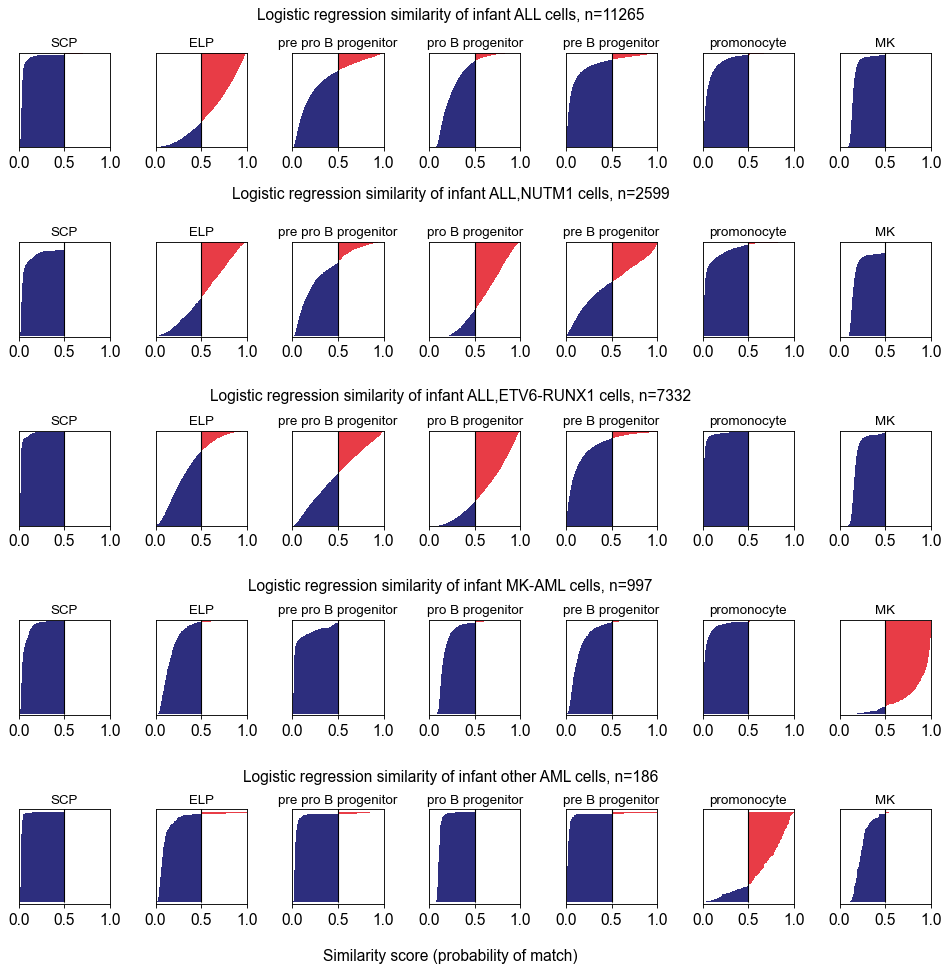

In [23]:
#Figure 2c
import matplotlib.pyplot as plt


ct2plot = ['SCP/Adr', 'ELP/BM','pre pro B progenitor/BM','pro B progenitor/BM', 'pre B progenitor/BM', 'promonocyte/BM', 'MK/BM']
title2plot = ['ALL', 'ALL,NUTM1', 'ALL,ETV6-RUNX1','MK-AML', 'other AML']
titlepos = [0.94, 0.78, 0.6,0.43, 0.26]

fig = plt.figure(constrained_layout=False, figsize = (20,14))
spec = fig.add_gridspec(ncols=len(ct2plot), nrows=5, wspace = 0.5, hspace = 1)

for j, dd in enumerate(['iALL',  '_NUTM1','_ETV6',  'P9', 'P10']):
    print(dd)
    adata_ALLAML_sub = adata_new[(adata_new.obs.patient_cancer.str.contains(dd)) & 
              (adata_new.obs.patient_cancer.str.contains('Cancer')) & 
              (adata_new.obs.patient_cancer.str.count('_')==1 if dd=='iALL' else True)].copy()
    for i,d in enumerate(ct2plot):
        host = fig.add_subplot(spec[j,i])
        host.set_rasterization_zorder(1)
        fig.subplots_adjust(right=0.75)
        tmp = [x[0]-0.5 for x in adata_ALLAML_sub[:,d].X]
        tmp = pd.DataFrame({'value': sorted(tmp)})
        tmp['positive'] = tmp > 0         
        host.barh(range(len(tmp)),tmp.value, left = 0.5, height = 1, color=tmp.positive.map({True: '#E83C46', False: '#2D2E7E'}),zorder=0)
        host.vlines(0.5, ymin=0,ymax=len(tmp)+50, color = 'k', linewidth = 1)
        host.set_xlim([0,1])
        host.set_ylim([-5, len(tmp)+5])
        host.set_xticks([0,0.5,1])
        host.set_title(ct2plot[i].split('/')[0],fontsize = 12)
        host.set_yticks([])
     

    fig.text(0.45, titlepos[j], 'Logistic regression similarity of infant '+ title2plot[j] +' cells, n='+str(len(tmp)), ha='center')

fig.text(0.45, 0.1, 'Similarity score (probability of match)', ha='center')



<a id='deconvolution'></a>


# Bulk RNA-seq deconvolution

Deconvolution analysis of bulk RNA-seq leukemia samples from St.Jude and TARGET cohorts.

/Users/ek12/homebrew/lib/python3.7/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  _ = ax.pcolor(_color_df, **kwds)


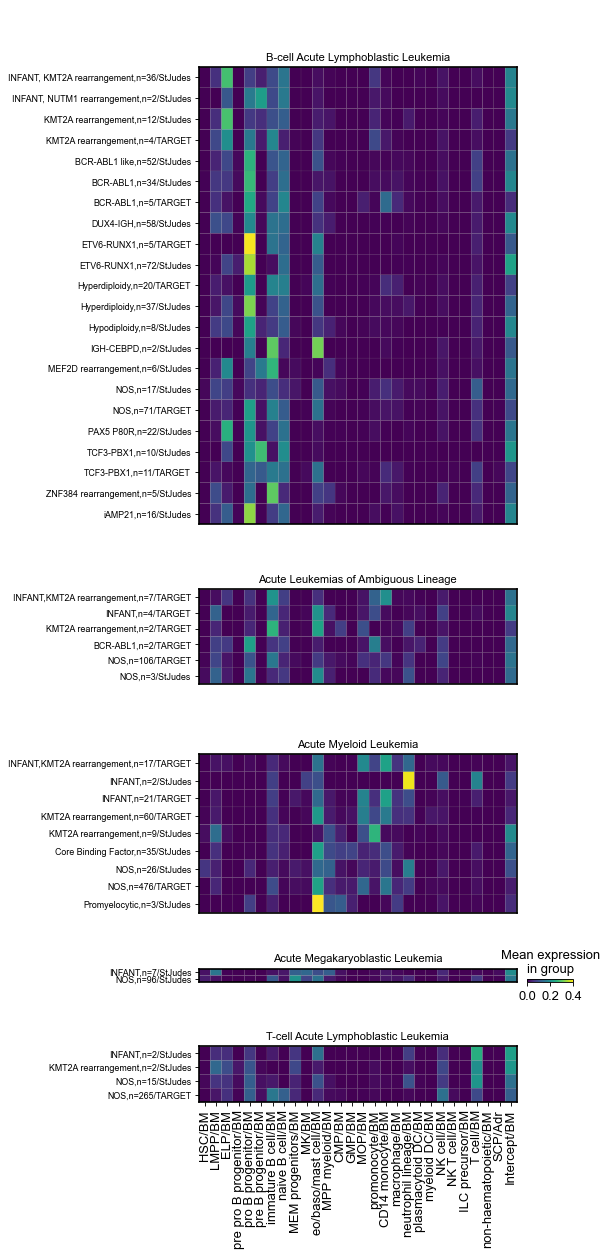

In [28]:
import pandas as pd
import scanpy as sc

# rewritten function from R to Python 
# original function written in R is in cellSignalAnalysis.R script 
# in https://github.com/constantAmateur/cellSignalAnalysis
# Load's the exposure table, separates out the goodness-of-fit metrics and exposures and normalises the exposures to sum to 1 across each sample.
def normaliseExposures(tgt):
    #Is this just the base?
    fit = pd.read_csv(tgt,sep='\t')
    fit = fit[sorted(fit.columns)]
    #Extract the goodness of fit rows
    gofNoms = ['pR2','fitCount','obsCount']
    gof = fit.loc[gofNoms]
    gof.loc['log2(countRatio)'] = np.log2(gof.loc['fitCount']/gof.loc['obsCount'])
    exposures = fit.loc[~fit.index.isin(gofNoms)]
    exposures = exposures/exposures.sum(0)
    #Done
    return {'exposures': exposures, 'gof': gof,'raw':fit.loc[~fit.index.isin(gofNoms)]}


celltype_2plot = ['HSC/BM', 'LMPP/BM', 'ELP/BM','pre pro B progenitor/BM', 'pro B progenitor/BM', 'pre B progenitor/BM', 'immature B cell/BM', 'naive B cell/BM',
      'MEM progenitors/BM', 'MK/BM', 'eo/baso/mast cell/BM', 'MPP myeloid/BM', 'CMP/BM', 'GMP/BM', 'MOP/BM', 'promonocyte/BM', 'CD14 monocyte/BM',
      'macrophage/BM','neutrophil lineage/BM', 'plasmacytoid DC/BM', 'myeloid DC/BM', 'NK cell/BM', 'NK T cell/BM', 'ILC precursor/BM',
      'T cell/BM', 'non-haematopoietic/BM', 'SCP/Adr', 'Intercept/BM']


stjudes_path = 'analysis_results/deconvolution/StJudes_deconvFetalBM_Broad400wSCP_fitExposures.tsv'
target_path = 'analysis_results/deconvolution/TARGET_deconvFetalBM_Broad400wSCP_fitExposures.tsv'

stjudes_meta = pd.read_csv('data/bulk_data/StJude/StJude_Metadata_final_filtered.csv', sep = ',', index_col=0)
fit = normaliseExposures(stjudes_path)
fit = fit['exposures']
fit.columns = pd.Series(fit.columns).str.split('.', expand = True, n=1)[0].values
adata_stjudes = sc.AnnData(fit.T)
adata_stjudes = adata_stjudes[adata_stjudes.obs_names.isin(stjudes_meta.index)]
adata_stjudes.obs = stjudes_meta

target_meta = pd.read_csv('data/bulk_data/TARGET/TARGET_Metadata_final_filtered.csv', index_col=0)
fit = normaliseExposures(target_path)
fit = fit['exposures']
fit.columns = pd.Series(fit.columns).str.split('.', expand = True, n=1)[0].values
adata_target = sc.AnnData(fit.T)
adata_target = adata_target[adata_target.obs_names.isin(target_meta.index.values)]
adata_target.obs = target_meta


adata_leukcomb = adata_stjudes.concatenate(adata_target, batch_categories = ['StJudes', 'TARGET'])
adata_leukcomb = adata_leukcomb[~adata_leukcomb.obs.disease_subtype.str.contains('n=1/')]
adata_leukcomb.var_names = adata_leukcomb.var_names + '/BM'
vn = pd.Series(adata_leukcomb.var_names)
vn[vn == 'SCP/BM'] = 'SCP/Adr'
adata_leukcomb.var_names = vn.values

fig = plt.figure(constrained_layout=False, figsize = (6,18))

disorder = ['B-cell Acute Lymphoblastic Leukemia',
            'Acute Leukemias of Ambiguous Lineage',
            'Acute Myeloid Leukemia',
            'Acute Megakaryoblastic Leukemia',
            'T-cell Acute Lymphoblastic Leukemia']


height_ratios = adata_leukcomb.obs.groupby('disease_type').disease_subtype.nunique().loc[disorder].sum()
height_ratios = np.ceil((adata_leukcomb.obs.groupby('disease_type').disease_subtype.nunique().loc[disorder]/height_ratios*100))

spec = fig.add_gridspec(ncols=1, nrows=len(disorder),hspace = 0.1, height_ratios=height_ratios)

for i,d in enumerate(disorder):
    ax2 = fig.add_subplot(spec[i],aspect='auto')
    adata_tmp = adata_leukcomb[adata_leukcomb.obs.disease_type == d].copy()
    adata_tmp.obs.disease_subtype = adata_tmp.obs.disease_subtype.astype('category')
    adata_tmp.obs = adata_tmp.obs.astype('category')
    ll = list(adata_tmp.obs.disease_subtype.cat.categories)
    ll2 = [x for x in ll if 'INFANT' in x]
    ll2.extend([x for x in ll if 'KMT2A' in x and 'INFANT' not in x])
    ll2.extend(np.setdiff1d(ll, ll2))
    adata_tmp.obs.disease_subtype = adata_tmp.obs.disease_subtype.cat.reorder_categories(ll2)  
    f = sc.pl.matrixplot(adata_tmp, celltype_2plot, groupby='disease_subtype', dendrogram=False,show = False,cmap='viridis', ax=ax2,vmax = 0.4)
    f['mainplot_ax'].tick_params(axis="y", labelsize=8)#, rotation = 180)
    f['mainplot_ax'].set_title(d, fontsize = 10)#, rotation = 180)
    if i<len(disorder)-1:
        f['mainplot_ax'].set_xticks([])

    if i!=len(disorder)-2:
        f['color_legend_ax'].set_visible(False)        